In [1]:
import os

import pandas as pd
import numpy as np

from python.parameters import *
from python.components import *
from python.utils import *
from python.experiment import *

In [2]:
results_folder = 'results'
# thermal_folder = os.path.join(results_folder, 'thermal')
test_folder = os.path.join(results_folder, 'test')
ttc_folder = os.path.join(results_folder, 'ttc')

In [3]:
components_csv = 'data/components.csv'
eclipse_csv = 'data/STK/Satellite_Eclipse_Times.csv'
solar_angles_csv = 'data/STK/Satellite_solar_angles.csv'
target_csv = 'data/STK/Satellite_Satellite_Sensor_Hyperscout2_To_AreaTarget_Europe_Access.csv'
# GS_0_csv = 'data/STK/Satellite-Satellite-To-Facility-Esrange_Station_ESC-Sensor-Esrange_Access.csv'
# GS_1_csv = 'data/STK/Satellite-Satellite-To-Facility-Svalsat_SG_1_STDN_SG1S-Sensor-Svalbard_Access.csv'
GS_0_csv = 'data/STK/Satellite-Satellite-To-Facility-Esrange_Station_ESC_Access.csv'
GS_1_csv = 'data/STK/Satellite_Satellite_To_Facility_Svalsat_SG_1_STDN_SG1S_Access.csv'

In [4]:
eclipse_df = pd.read_csv(eclipse_csv)
solar_angles_df = pd.read_csv(solar_angles_csv)
target_df = pd.read_csv(target_csv)
GS_0_df = pd.read_csv(GS_0_csv)
GS_1_df = pd.read_csv(GS_1_csv)

In [5]:
components_params = csvtoparameters(components_csv)
solar_params = SolarCellParameters()
battery_params = BatteryCellParameters()
ttc_params = TTCParameters()
heater_params = HeaterParameters()
payload_params = PayloadParameters()

EOL = False

In [6]:
solar_panels = [
    SolarPanel(solar_params, eclipse_df, n_series=5, n_parallel=2, EOL=EOL),
    SolarPanel(solar_params, eclipse_df, n_series=5, n_parallel=2, EOL=EOL),
    SolarPanel(solar_params, eclipse_df, n_series=5, n_parallel=2, EOL=EOL),
    SolarPanel(solar_params, eclipse_df, n_series=5, n_parallel=2, EOL=EOL),
]
# solar_panels = [
#     SolarPanel(solar_params, eclipse_df, n_series=6, n_parallel=3, face='x', angle_data=solar_angles_df, EOL=EOL),
#     SolarPanel(solar_params, eclipse_df, n_series=6, n_parallel=2, face='z', angle_data=solar_angles_df, EOL=EOL),
# ]

components = list()
for params in components_params:
    components.append(Component(params, eclipse_df))

battery_packs = [
    BatteryPack(battery_params, n_series=4, n_parallel=2, EOL=EOL),
    BatteryPack(battery_params, n_series=4, n_parallel=2, EOL=EOL)
]

heaters = [
    Heater(heater_params, eclipse_df),
    Heater(heater_params, eclipse_df)
]

ttcs = [
    TTC(ttc_params, mode='S-band', sunlight=True, GS_data=[GS_0_df, GS_1_df], eclipse_data=eclipse_df),
    TTC(ttc_params, mode='UHF', sunlight=False, target=True, eclipse_data=eclipse_df, target_data=target_df)
]

payload = Payload(payload_params, target_df, eclipse_df)

In [7]:
schedules = {
    'day_1': ['acquisition', 'elaboration', 'transfer'],
    'day_2': ['acquisition', 'elaboration', 'transfer'],
    'day_3': ['acquisition', 'elaboration', 'transfer'],
    'day_4': ['acquisition', 'elaboration', 'transfer'],
    'day_5': ['acquisition', 'elaboration', 'transfer', 'download'],
    'day_6': ['download'],
    'day_7': ['download'],
}

experiment = Experiment(payload,
                        solar_panels,
                        battery_packs,
                        ttcs,
                        components,
                        heaters,
                        test_folder)

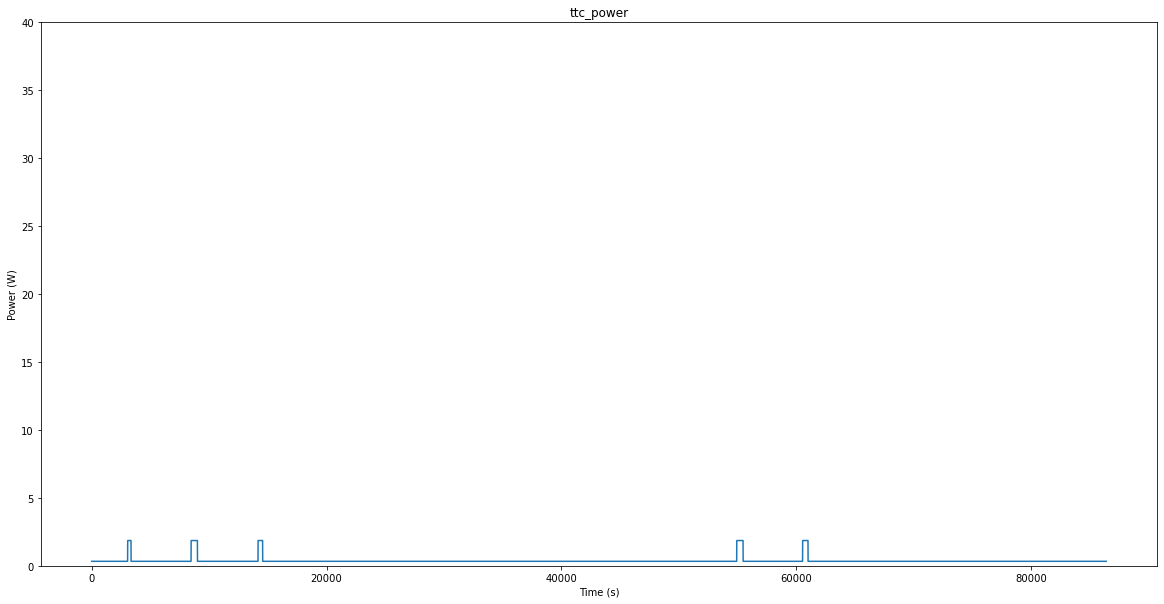

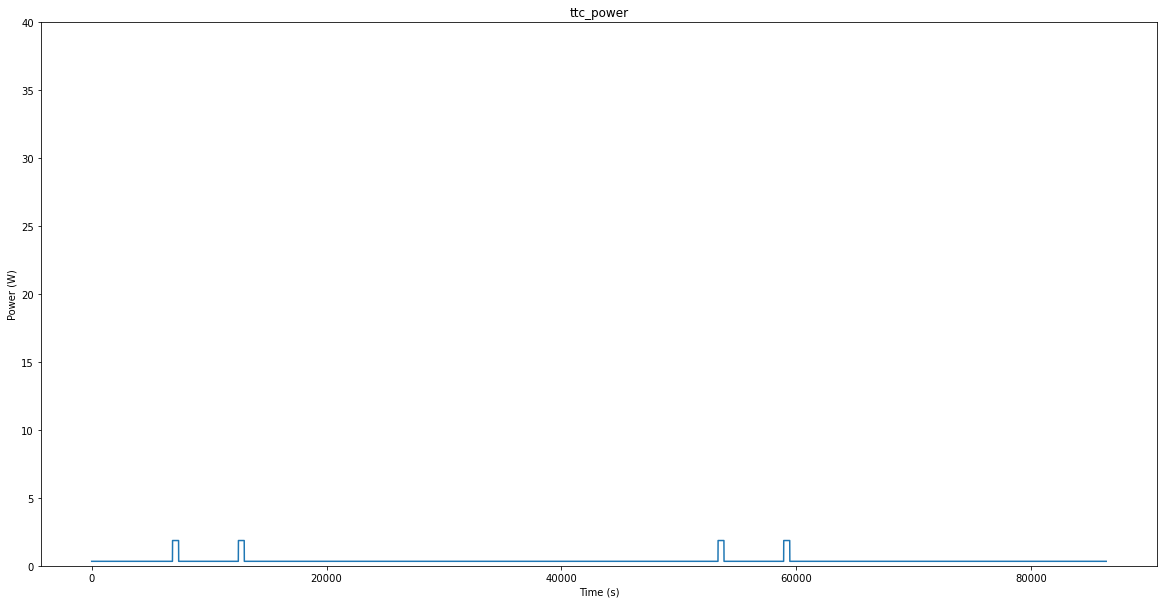

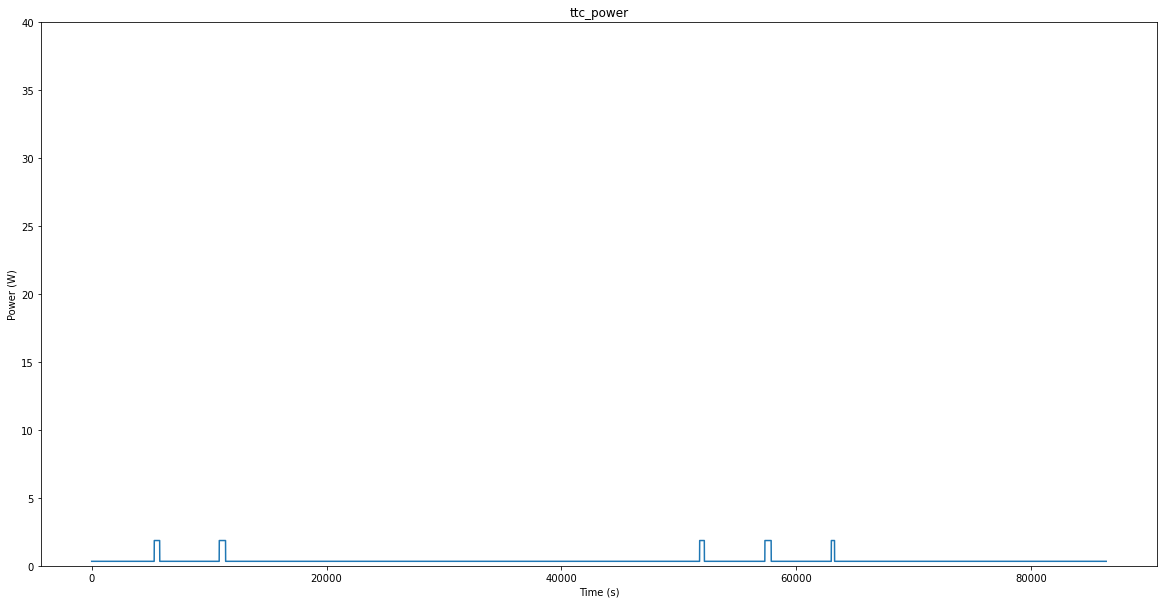

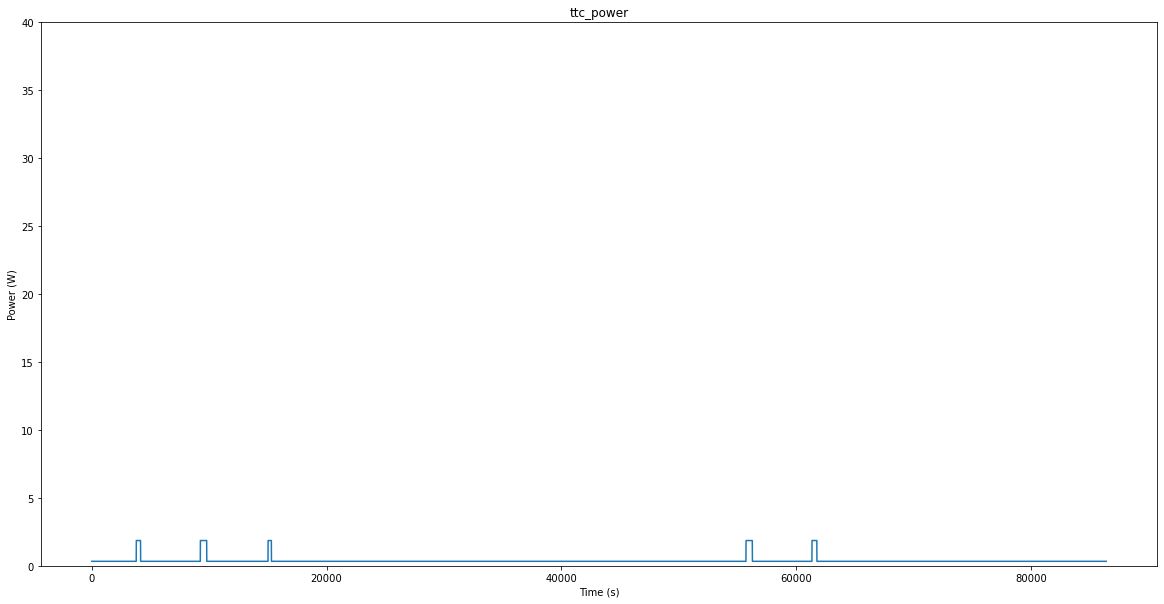

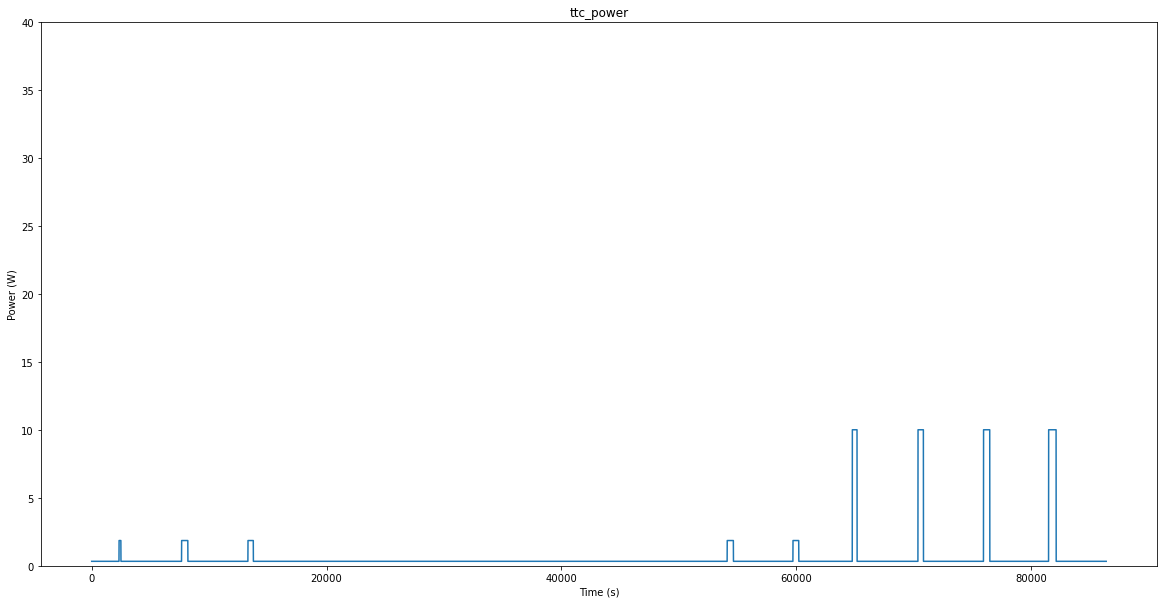

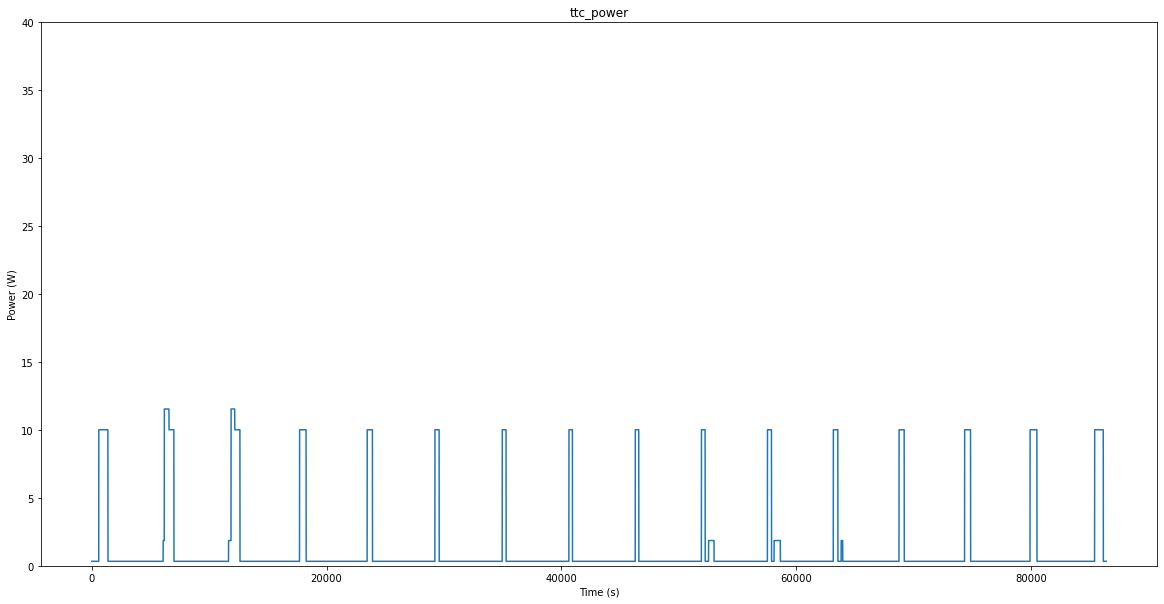

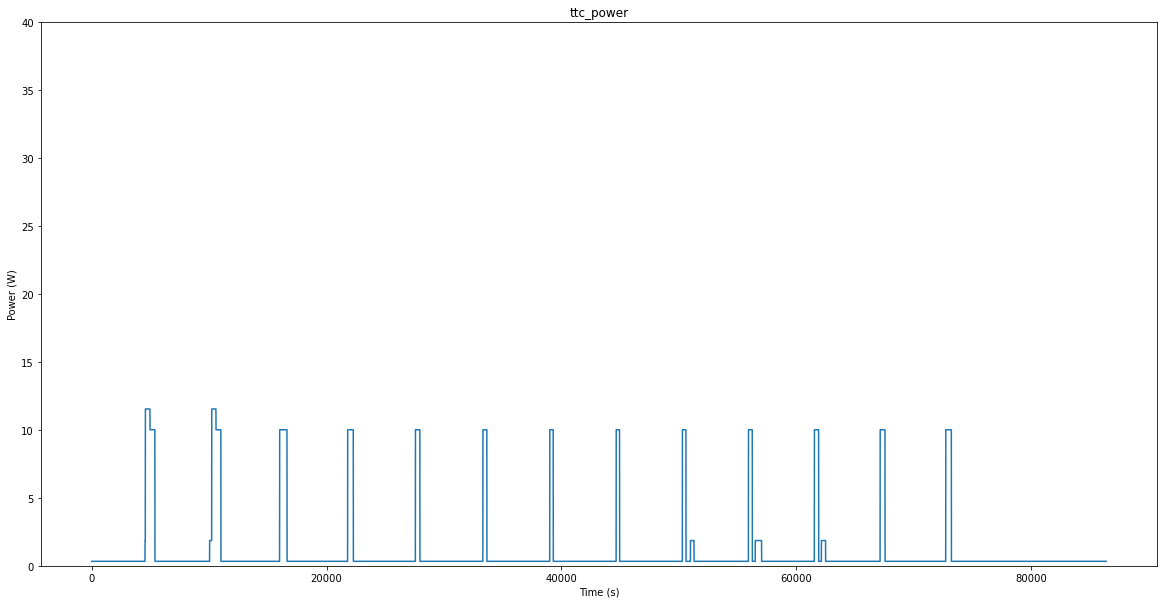

In [9]:
experiment.reset()
skip = 3600 * 8
# skip += 3600 * 24 * 7 * 3
experiment.skiptime(skip)

time = 0
for key, schedule in schedules.items():
    time = experiment.day(key, schedule, time)
    # experiment.csv_thermal()
    # experiment.plot_thermal()
    experiment.plot(['input_power', 'total_load_power', 'ttc_power',
                     ['batteries', 'input_power'], ['batteries', 'output_power'], ['batteries', 'DOD']])
    # experiment.csv(['input_power', 'total_load_power', ['batteries', 'DOD']])
    # experiment.plot(['ttc_power'])
    # experiment.csv(['ttc_power', 'UHF_status', 'S-band_status'])